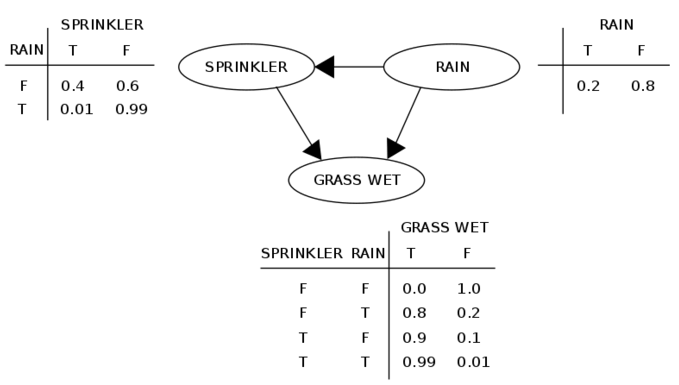

In [1]:

import math
import torch
import pyro
import pyro.distributions as dist

In [2]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sat Jun 29 2024

Python implementation: CPython
Python version       : 3.9.19
IPython version      : 8.18.1

pyro : 1.9.1
torch: 2.3.0

Watermark: 2.4.3



In [18]:


def model(rain=None, sprinkler=None, grasswet=None):
    if rain is None:
        s_rain = pyro.sample('rain', dist.Bernoulli(0.2))
    else:
        s_rain = pyro.sample('rain', dist.Bernoulli(0.2), obs=rain)

    sprinkler_probs = ( 0.01 * s_rain) + (0.4 * (1 - s_rain))
    if sprinkler is None:
        s_sprinkler = pyro.sample('sprinkler', dist.Bernoulli(sprinkler_probs))
    else:
        s_sprinkler = pyro.sample('sprinkler', dist.Bernoulli(sprinkler_probs), obs=sprinkler)
    
    grasswet_probs = 0. * (1 - s_sprinkler) * (1 - s_rain) + 0.8 * (1 - s_sprinkler) * s_rain \
        + 0.9 * s_sprinkler * (1 - s_rain) + 0.99 * s_sprinkler * s_rain
    if grasswet is None:
        s_grasswet = pyro.sample('grasswet', dist.Bernoulli(grasswet_probs))
    else:
        s_grasswet = pyro.sample('grasswet', dist.Bernoulli(grasswet_probs), obs=grasswet)
    
    return s_rain, s_sprinkler, s_grasswet


F, T = torch.tensor(0.), torch.tensor(1.)
pyro.render_model(model, model_args=(F,F,F,), render_params=True, render_distributions=True)
model()

(tensor(0.), tensor(1.), tensor(1.))

In [4]:
# this is used when we have discrete random variable with are latent or needs marginalization
enum_model = pyro.infer.config_enumerate(model)
guide = lambda **kwargs: None
elbo = pyro.infer.TraceEnum_ELBO(max_plate_nesting=0)

### Test CPTs

In [5]:
conditional_marginals = elbo.compute_marginals(enum_model, guide)
print(conditional_marginals)
print("p(rain=T):", conditional_marginals["rain"].log_prob(T).exp())

OrderedDict([('rain', Bernoulli(logits: -1.3862944841384888)), ('sprinkler', Bernoulli(logits: -0.7445956468582153)), ('grasswet', Bernoulli(logits: -0.20721828937530518))])
p(rain=T): tensor(0.2000)


In [6]:
conditional_marginals = elbo.compute_marginals(enum_model, guide, rain=T)
print("p(sprinkler=T|rain=T):", conditional_marginals["sprinkler"].log_prob(T).exp())

p(sprinkler=T|rain=T): tensor(0.0100)


In [7]:
conditional_marginals = elbo.compute_marginals(enum_model, guide, sprinkler=T, rain=T)
print("p(grasswet=T|sprinkler=T,rain=T):", conditional_marginals["grasswet"].log_prob(T).exp())

p(grasswet=T|sprinkler=T,rain=T): tensor(0.9900)


### Compute conditional marginals

In [8]:
conditional_marginals = elbo.compute_marginals(enum_model, guide, sprinkler=F, grasswet=F)
p_r_T_given_s_F_g_F = conditional_marginals["rain"].log_prob(T).exp()
print("p(rain=T|sprinkler=F,grasswet=F):", p_r_T_given_s_F_g_F)
print("p(rain=F|sprinkler=F,grasswet=F):", 1 - p_r_T_given_s_F_g_F)


p(rain=T|sprinkler=F,grasswet=F): tensor(0.0762)
p(rain=F|sprinkler=F,grasswet=F): tensor(0.9238)


In [9]:
conditional_marginals = elbo.compute_marginals(enum_model, guide, rain=T)
print("p(sprinkler=T|rain=T):", conditional_marginals["sprinkler"].log_prob(T).exp())
print("p(grasswet=T|rain=T):", conditional_marginals["grasswet"].log_prob(T).exp())

p(sprinkler=T|rain=T): tensor(0.0100)
p(grasswet=T|rain=T): tensor(0.8019)


In [10]:
conditional_marginals = elbo.compute_marginals(enum_model, guide, sprinkler=F)
print("p(rain=T|sprinkler=F):", conditional_marginals["rain"].log_prob(T).exp())
print("p(grasswet=T|sprinkler=F):", conditional_marginals["grasswet"].log_prob(T).exp())

p(rain=T|sprinkler=F): tensor(0.2920)
p(grasswet=T|sprinkler=F): tensor(0.2336)


### using bayes rule 

Now, to compute p(rain=F|grasswet=F,sprinkler=F), we need to compute p(rain=F,grasswet=F,sprinkler=F) and p(grasswet=F,sprinkler=F).

$$ \color{red}{P(rain=F, sprinkler=F, wetgrass=F)} \\ \color{lightgray}{ = P(rain=F) P(sprinkler=F|rain=F) P(wetgrass=F|sprinker=F,rain=F)}$$

$$(rain=F, sprinkler=F, wetgrass=F)$$

In [11]:
# compute p(rain=F,grasswet=F,sprinkler=F)
# from CPT 0.8*0.6*1.0 = P(rain=F)*P(sprinkler=F|rain=F)*P(wetgrass=F|sprinker=F,rain=F)
p_rain_F_sprinkler_F_grasswet_F = pyro.poutine.trace(model).get_trace(F, F, F).log_prob_sum().exp()
print("p(rain=F,sprinkler=F,grasswet=F):", p_rain_F_sprinkler_F_grasswet_F)

p(rain=F,sprinkler=F,grasswet=F): tensor(0.4800)


In [12]:
# compute p(grasswet=F,sprinkler=F)
p_sprinkler_F_grasswet_F = math.exp(-elbo.loss(enum_model, guide, sprinkler=F, grasswet=F))


In [13]:
# compute p(rain=F|sprinkler=F,grasswet=F)
print("p(rain=F|sprinkler=F,grasswet=F):", p_rain_F_sprinkler_F_grasswet_F / p_sprinkler_F_grasswet_F)

p(rain=F|sprinkler=F,grasswet=F): tensor(0.9238)


### Exercise

Try to build the below model and play with the learn functions. 

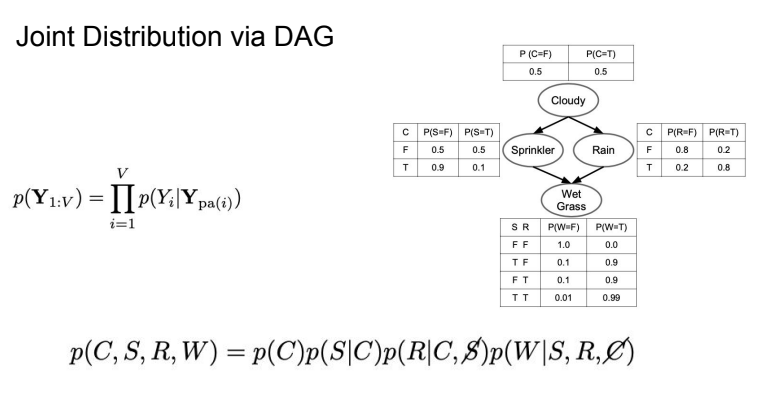